In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, date, time
import time
from scipy import stats
# import carbon_utils
import PyCO2SYS as pyco2
from scipy import interpolate
# from tabulate import tabulate
import re
import matplotlib.gridspec as gridspec


In [11]:
glodap_offsets_filename = 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4.nc'
# glodap_offsets_filename = 'glodap_offsets_100km_2_to_50_50m_0.1dens_0.1spice_5.nc'
# read in a user-created text file to point to local directories to avoid having to change this every time 
# we update code
lines=[]
with open('path_file.txt') as f:
    lines = f.readlines()
    
count = 0
for line in lines:
    count += 1
    index = line.find("=")
    #print(f'line {count}: {line}')
    #print(index)
    #print(line[0:index])
    line = line.rstrip()
    if line[0:index].find("argo")>=0:
        argo_path=line[index+1:]
    elif line[0:index].find("liar")>=0:
        liar_dir=line[index+1:]
    elif line[0:index].find("matlab")>=0:
        matlab_dir=line[index+1:]
        
# Set the paths
output_dir = 'output/'
data_dir = 'data/'

# Check for a glodap_offsets_plots directory, create if it does not exist
offset_dir = output_dir + 'glodap_offset_plots/'
if not os.path.isdir(offset_dir):
    os.mkdir(offset_dir)
individual_plot_dir = offset_dir + 'individual_floats' + glodap_offsets_filename[14:-3] + ' _by_days/'
if not os.path.isdir(individual_plot_dir):
    os.mkdir(individual_plot_dir)

if not os.path.isdir(individual_plot_dir + 'plots/'):
    os.mkdir(individual_plot_dir  + 'plots/')

### 1. Load offsets and look at offset summary plots for each float
This step helps to 1) identify patterns in float offsets in particular floats so that we can go back and refine offset criteria and 2) make final decisions about whether a float should be adjusted or not.

First load saved glodap offsets

In [3]:
if 'glodap_offsets' in locals():
    glodap_offsets.close()

glodap_offsets = xr.load_dataset(output_dir+glodap_offsets_filename)

In [4]:
#list of DOXY_ADJUSTED SCIENTIFIC_CALIB_COMMENT substrings to group together for bias analysis

#no calibration bad data
bad_cal_list = ['Sensor issue','out of order','Bad data; not adjustable','Biofouling','unadjustable']

#no calibration, reason unspecified
no_cal_list = ['no adjustment','No QC','none','not applicable']

#blank cal
blank_cal = ['                ']

#air cal
# air_cal_list = ['DOXY_ADJUSTED corrected using co','SVU Foil','Partial pressure','Bittig',
#                 'Adjusted with SAGEO2 using co','Adjusted with SAGEO2 with in-air',
#                 'PPOX converted from DOXY','G determined from float measure']
air_cal_list = ['in air', 'in-air']
#no air cal
noair_cal_surf_list = ['World Ocean Atlas', 'woa', 'WOA', 'no in-air', 'no in air', 
                       'climatology','DOXY_QCs are modified during visual check',
                      'Takeshita']
# ['DOXY_ADJUSTED is computed from','DOXY_ADJUSTED is estimated from',
#                        'Adjustment done on PPOX_DOXY;Tem','Polynomial calibration','Adjustment via comparison of',
#                       'optode multi calibration','RT adjustment by comparison','adjusted with median',
#                       'Adjusted with annual WOA','Adjusted on WOA monthly','Adjusted PPOX at zero for',
#                       'G determined by surface']

noair_cal_subsurf_list = []
# ['1-point multiplicative corr']

noair_cal_funcofdoxy_list = []
# ['Percent saturation corrected as','DOXY_ADJUSTED computed using Ste',
#                         'Oxygen concentration corrected']

noair_cal_unspec_list = []
# ['DOXY_ADJUSTED corrected based','Adjust with WOA monthly','GAIN determined from WOA2013',
#                         'Adjusted with WOA climatology','Adjusted with SAGEO2 based on WO',
#                          'Adjusted with SAGEO2 on WOA','Adjusted with WOA 2018','Takeshita and all, 2013']

noair_cal_withdrift_list = []
# ['Adjustment done on PPOX_DOXY;Tem'] #this is incomplete

noair_cal_combined_list = noair_cal_surf_list+noair_cal_subsurf_list+noair_cal_funcofdoxy_list+noair_cal_unspec_list

In [83]:
time_since_deployment = [0, 10, 20, 50, 75, 100]
print(time_since_deployment)

[0, 10, 20, 50, 75, 100]


In [20]:
print(day_difference)
print(g.main_float_juld)
print(g.glodap_datetime)

<xarray.DataArray (N_CROSSOVERS: 6)>
array([3975.48253472, 3975.48253472, 3254.22767361, 3975.48253472,
       3719.97072917, 3254.22767361])
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 754675 754676 754677 754678 754679 754680
<xarray.DataArray 'main_float_juld' (N_CROSSOVERS: 6)>
array(['2022-10-24T11:36:51.000000256', '2022-10-29T11:36:39.999999744',
       '2022-10-29T11:36:39.999999744', '2022-11-03T11:35:20.000001024',
       '2022-11-03T11:35:20.000001024', '2022-11-03T11:35:20.000001024'],
      dtype='datetime64[ns]')
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 754675 754676 754677 754678 754679 754680
<xarray.DataArray 'glodap_datetime' (N_CROSSOVERS: 6)>
array(['2011-12-06T00:02:00.000000000', '2011-12-06T00:02:00.000000000',
       '2013-11-26T06:09:00.000000000', '2011-12-06T00:02:00.000000000',
       '2012-08-17T12:19:00.000000000', '2013-11-26T06:09:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * N_CROSSOVERS  (N_CROSSOVERS) int64 754675 7

In [53]:
# glodap_offsets

# time_since_deployment = np.linspace(0, 100, 10)
# time_since_deployment = [-2, 10, 20, 50, 75, 100, 365, 1835]
time_since_deployment = [-2, 10, 100, 365, 1825]

for j in range(len(time_since_deployment) - 1):
    print(str(time_since_deployment[j]) + '_days_to_' + str(time_since_deployment[j+1]) + '_days')

    # iteratively go through glodap_offsets, masking out all values that don't fit your time range, and saving netcdf files. 
    # Then you can look through how those values change over time
    #group by main float wmo
    offsets_g = glodap_offsets.groupby(glodap_offsets.main_float_wmo)

    DOXY_ADJUSTED_offset_trimmed = []


    float_count=0
    for n,g in offsets_g:
        float_count = float_count + 1

        # difference in days between glodap and float crossover
        # day_difference = (g.glodap_datetime - g.main_float_juld) / np.timedelta64(1, 'D')
        day_difference = (g.main_float_juld[0] - g.glodap_datetime) / np.timedelta64(1, 'D')

        day_index = np.logical_and(day_difference>=time_since_deployment[j],
                day_difference<time_since_deployment[j+1])
        
        temp_o2_offset = g.DOXY_ADJUSTED_offset.where(day_index)

        # append each temp_o2_offset to the new DOXY_ADJUSTED_offset_trimmed vector
        DOXY_ADJUSTED_offset_trimmed.append(temp_o2_offset.values)

        # if sum(day_index)>0:
        #     break
    # concatenate all vectors within DOXY_ADJUSTED_offset_trimmed (each represents one WMO)
    result_vector = np.concatenate(DOXY_ADJUSTED_offset_trimmed)
    # convert to Xarray DataArray
    result_da = xr.DataArray(result_vector, dims='N_CROSSOVERS', coords={'N_CROSSOVERS': glodap_offsets['N_CROSSOVERS']})
    # add to glodap_offsets
    glodap_offsets['DOXY_ADJUSTED_offset_trimmed']=result_da
    # print(glodap_offsets)

    # then group again by WMO, now with the new variable:
    offsets_g = glodap_offsets.groupby(glodap_offsets.main_float_wmo)
    # create the mean dataset
    glodap_offsets_mean = offsets_g.mean(skipna='True')

    #initialise metadata DataArrays
    varnames = ['o2_calib_comment','o2_calib_equation','o2_calib_coeff','o2_calib_group','o2_calib_air_group',
            'o2_calib_drift','project_name','plat_type','data_centre']
    coord= range(glodap_offsets_mean.main_float_wmo.shape[0])
    for v in varnames:
        glodap_offsets_mean[v] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)

    #also create groups by sensor 
    glodap_offsets_mean['pH_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
    glodap_offsets_mean['pH_sensor'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
    glodap_offsets_mean['nitrate_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
    glodap_offsets_mean['nitrate_sensor'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
    glodap_offsets_mean['DOXY_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)
    glodap_offsets_mean['DOXY_sensor'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)

    #group for floats that have some under ice profiles with some air calibrated some not
    glodap_offsets_mean['ice_group'] = xr.DataArray(dims=['main_float_wmo'],coords={'main_float_wmo':coord}).astype(str)

    num_crossovers = glodap_offsets_mean.main_float_wmo.size

    # loop through each wmo in offsets
    for n,w in enumerate(glodap_offsets_mean.main_float_wmo):
        
        #find full float file matching offset
        wmo_n = w.values
        fn = argo_path + str(wmo_n) + '_Sprof.nc'
        float_og = xr.open_dataset(fn)
        
        #also load meta file  for same float
        fn1 = argo_path + str(wmo_n) + '_meta.nc'
        meta_og = xr.open_dataset(fn1)

        #option for multiple calibrations at different times- default to use most recent only for now?
        #O2 calibration
        #if len(float_og.N_CALIB) >1 :
            #print(str(g.values)+' has more than 1 calibration')
        
        no_cal = []
        if 'DOXY_ADJUSTED' in float_og.keys():
            is_doxy = 'DOXY'
            
            #get O2 sensor type
            #check sensor index
            sensors = meta_og.SENSOR.values
            sind = [idx for idx, s in enumerate(sensors) if 'DOXY' in s.decode("utf-8")] 
            #grab sensor model for index
            if len(sind):
                o2_sensor = meta_og.SENSOR_MODEL.values[sind[0]].decode("utf-8")
            else:
                o2_sensor = 'not listed'

            cal_str = float_og.STATION_PARAMETERS.values.astype(str)[0]
            o2_ind = [idx for idx, s in enumerate(cal_str) if 'DOXY' in s]
            if len(o2_ind):
    
                
                #get calibration info
                o2_cal_full = float_og.SCIENTIFIC_CALIB_COMMENT.values[:,-1,o2_ind[0]]
                o2_cal_date = float_og.SCIENTIFIC_CALIB_DATE.values[:,-1,o2_ind[0]]
                o2_cal_unique = np.unique(o2_cal_full)
                
                #check if any unique cal comments are bad/no cal
                isbad = []
                for i in range(len(o2_cal_unique)):
                    o2_cal_i = o2_cal_unique[i].decode("utf-8")
                    if any(substring in o2_cal_i for substring in bad_cal_list) or \
                    any(substring in o2_cal_i for substring in no_cal_list) or \
                    any(substring in o2_cal_i for substring in blank_cal):
                        isbad.append(i)
                #remove bad indices
                o2_cal_unique = np.delete(o2_cal_unique,isbad)

                #check if more than one unique calibration comment remaining after excluding bad data
                if len(o2_cal_unique)>1:
                    print('multiple cal comments')  
                    print(wmo_n)
                    #how to integrate multiple comments? Do any contain different groupings?
                    o2_cal = float_og.SCIENTIFIC_CALIB_COMMENT.values[0,-1,o2_ind[0]].decode("utf-8")
                    if np.any(float_og.POSITION_QC.values==8):
                        under_ice = 'some air cal, some under ice'
                        print('under ice')
                    else:
                        under_ice = 'no ice'
                        
                else:
                    o2_cal = float_og.SCIENTIFIC_CALIB_COMMENT.values[0,-1,o2_ind[0]].decode("utf-8")
                o2_eq = float_og.SCIENTIFIC_CALIB_EQUATION.values[0,-1,o2_ind[0]].decode("utf-8")
                o2_co = float_og.SCIENTIFIC_CALIB_COEFFICIENT.values[0,-1,o2_ind[0]].decode("utf-8")
                under_ice = 'no ice'
            else:
                o2_cal = 'empty O2 calib comment'
                o2_eq = 'none'
                o2_co = 'none'

        else:
            is_doxy = 'no DOXY'
            o2_cal = 'no O2'
            o2_eq = 'none'
            o2_co = 'none'
            o2_sensor = 'none'
        

        ######## group calibration comments into categories
        
        #o2 calib comment groups
        if any(substring in o2_cal for substring in bad_cal_list):
            o2_group = 'bad'
        elif any(substring in o2_cal for substring in no_cal_list):
            o2_group = 'no cal'
        elif any(substring in o2_cal for substring in noair_cal_surf_list): # should catch the "no air cal" ones before they get put in air-cal list...
            o2_group = 'no air surface cal'
        elif any(substring in o2_cal for substring in air_cal_list):
            o2_group = 'air cal'
        elif any(substring in o2_cal for substring in noair_cal_subsurf_list):
            o2_group = 'no air subsurface cal'
        elif any(substring in o2_cal for substring in noair_cal_funcofdoxy_list):
            o2_group = 'no air function of DOXY cal'
        elif any(substring in o2_cal for substring in noair_cal_unspec_list):
            o2_group = 'no air unspecified'
        else:
            o2_group = 'ungrouped'
        
        
        #group O2 air cal and no air cal meta groups
        if any(substring in o2_cal for substring in air_cal_list):
            o2_air_group = 'air cal'
        elif any(substring in o2_cal for substring in noair_cal_combined_list):
            o2_air_group = 'no air cal'
        else:
            o2_air_group = 'no cal/bad'
            
        #separate groups for drift/no drift
        if any(substring in o2_cal for substring in noair_cal_withdrift_list):
            o2_group_drift = 'drift corrected'
        else:
            o2_group_drift = 'no drift corrected'
        
        if 'PH_IN_SITU_TOTAL_ADJUSTED' in float_og.keys():
            is_pH = 'pH'
            #get pH sensor type
            #check sensor index
            sensors = meta_og.SENSOR.values
            sind = [idx for idx, s in enumerate(sensors) if 'PH' in s.decode("utf-8")] 
            #grab sensor model for index
            pH_sensor = meta_og.SENSOR_MODEL.values[sind[0]].decode("utf-8")
        else:
            is_pH = 'no pH'
            pH_sensor = 'none'
        
        if 'NITRATE_ADJUSTED' in float_og.keys():
            is_nitrate = 'nitrate'
            #get nitrate sensor type
            #check sensor index
            sensors = meta_og.SENSOR.values
            sind = [idx for idx, s in enumerate(sensors) if 'NITRATE' in s.decode("utf-8")] 
            #grab sensor model for index
            nitrate_sensor = meta_og.SENSOR_MODEL.values[sind[0]].decode("utf-8")
        else:
            is_nitrate = 'no nitrate'
            nitrate_sensor = 'none'
        

        ###### get sensor information from meta files

        
        
        ##################################################
        #add metadata to glodap_offset Dataset
        glodap_offsets_mean.o2_calib_comment[n] = o2_cal
        glodap_offsets_mean.o2_calib_equation[n] = o2_eq
        glodap_offsets_mean.o2_calib_coeff[n] = o2_co
        glodap_offsets_mean.o2_calib_group[n] = o2_group
        glodap_offsets_mean.o2_calib_air_group[n] = o2_air_group
        glodap_offsets_mean.o2_calib_drift[n] = o2_group_drift
        glodap_offsets_mean.project_name[n] = float_og.PROJECT_NAME.values.astype(str)[0]
        glodap_offsets_mean.plat_type[n] = float_og.PLATFORM_TYPE.values.astype(str)[0]
        glodap_offsets_mean.data_centre[n] = float_og.DATA_CENTRE.values.astype(str)[0]
        glodap_offsets_mean.DOXY_group[n] = is_doxy
        glodap_offsets_mean.DOXY_sensor[n] = o2_sensor
        glodap_offsets_mean.pH_group[n] = is_pH
        glodap_offsets_mean.pH_sensor[n] = pH_sensor
        glodap_offsets_mean.nitrate_group[n] = is_nitrate
        glodap_offsets_mean.nitrate_sensor[n] = nitrate_sensor
        glodap_offsets_mean.ice_group[n] = under_ice
        
        print(str(n) + ' out of ' + str(num_crossovers))
    #save offsets with cal info
    glodap_offsets_mean.to_netcdf(individual_plot_dir+glodap_offsets_filename[0:-3]+ '_floatmean_withcalibration_' + str(time_since_deployment[j]) + '_days_to_' + str(time_since_deployment[j+1]) + '_days.nc')



-2_days_to_10_days
0 out of 1053
1 out of 1053
2 out of 1053
3 out of 1053
4 out of 1053
5 out of 1053
6 out of 1053
7 out of 1053
8 out of 1053
9 out of 1053
10 out of 1053
11 out of 1053
12 out of 1053
13 out of 1053
14 out of 1053
15 out of 1053
16 out of 1053
17 out of 1053
18 out of 1053
19 out of 1053
20 out of 1053
21 out of 1053
22 out of 1053
23 out of 1053
24 out of 1053
25 out of 1053
26 out of 1053
27 out of 1053
28 out of 1053
29 out of 1053
30 out of 1053
31 out of 1053
32 out of 1053
33 out of 1053
34 out of 1053
35 out of 1053
36 out of 1053
37 out of 1053
38 out of 1053
39 out of 1053
40 out of 1053
41 out of 1053
42 out of 1053
43 out of 1053
44 out of 1053
45 out of 1053
46 out of 1053
47 out of 1053
48 out of 1053
49 out of 1053
50 out of 1053
51 out of 1053
52 out of 1053
53 out of 1053
54 out of 1053
55 out of 1053
56 out of 1053
57 out of 1053
58 out of 1053
59 out of 1053
60 out of 1053
61 out of 1053
62 out of 1053
63 out of 1053
64 out of 1053
65 out of 1053
6

In [54]:
offsets_days = pd.DataFrame(columns=['Day', 'All', 'No Air', 'Air'])

for j in range(len(time_since_deployment) - 1):
    file = glodap_offsets_filename[0:-3]+ '_floatmean_withcalibration_' + str(time_since_deployment[j]) + '_days_to_' + str(time_since_deployment[j+1]) + '_days.nc'
    glodap_offsets_mean = xr.load_dataset(individual_plot_dir+file)
    glodap_offsets_p = glodap_offsets_mean.to_dataframe()

    parameter_a = 'o2_calib_air_group'
    parameter_b = 'pH_group'
    offsets_g = glodap_offsets_p.groupby(parameter_a)
    offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])
    ncount = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].count()
    nmean_all = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)

    o2_offset_data_table = [('All', ncount.item(), nmean_all.item(), nstd.item())]
    

    No_air_cal_all = offsets_g.get_group('no air cal')
    ncount = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].count() # only counts non-nan values
    nmean_no_air = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)

    o2_offset_data_table.append(('No air cal.', ncount.item(), nmean_no_air, nstd))

    air_cal_all = offsets_g.get_group('air cal')
    ncount = air_cal_all['DOXY_ADJUSTED_offset_trimmed'].count() # only counts non-nan values
    nmean_air = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)

    o2_offset_data_table.append(('Air cal', ncount.item(), nmean_air, nstd))
    mean_time = np.mean([time_since_deployment[j], time_since_deployment[j+1]])
    offsets_days_data = [(mean_time, 
                            nmean_all.item(), 
                            nmean_no_air, nmean_air)]

    offsets_days_data_n= pd.DataFrame(offsets_days_data, columns=['Day', 'All', 'No Air', 'Air'])
    offsets_days = pd.concat([offsets_days, offsets_days_data_n], ignore_index=True)


In [55]:
offsets_days

,Day,All,No Air,Air
0,4.0,-1.8,-0.8,-3.4
1,55.0,-1.5,-1.3,-3.1
2,232.5,-2.2,-1.7,-4.8
3,1095.0,-2.4,-1.7,-4.0


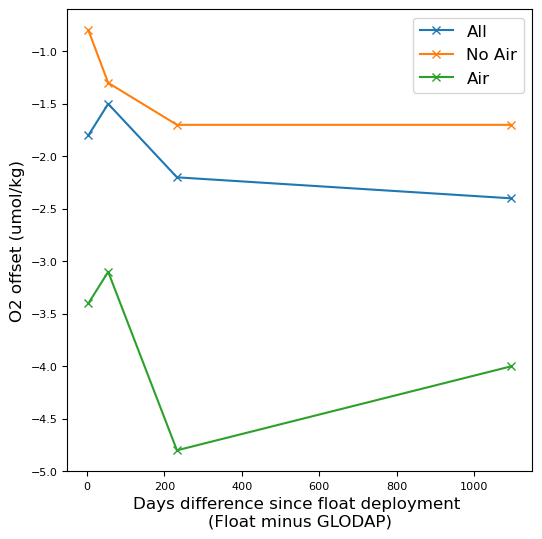

In [65]:
plt.figure(figsize=(6,6))
plt.subplot(1,1,1)
plt.plot(offsets_days['Day'], offsets_days['All'], 'x-', label='All')
plt.plot(offsets_days['Day'], offsets_days['No Air'], 'x-', label='No Air')
plt.plot(offsets_days['Day'], offsets_days['Air'], 'x-', label='Air')

plt.xlabel('Days difference since float deployment \n(Float minus GLODAP)')
plt.ylabel('O2 offset (umol/kg)')

plt.legend()
plt.tick_params(axis='both', labelsize=8)
plt.savefig(individual_plot_dir+ 'plots/' + 'Summary_plot.png', dpi=300)

In [57]:
# get netcdf files for different days
days_list = []
for file in os.listdir(individual_plot_dir):
    
    if file.endswith('.nc'):
        days_list.append(file)

#last = 0
print(days_list)

['glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_10_days_to_100_days.nc', 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_100_days_to_365_days.nc', 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_-2_days_to_10_days.nc', 'glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_365_days_to_1825_days.nc']


glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_10_days_to_100_days.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:30: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:74: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:99: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:124: DeprecationWarning: Use of keyword argum

glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_100_days_to_365_days.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:30: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:74: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:99: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:124: DeprecationWarning: Use of keyword argum

glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_-2_days_to_10_days.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:30: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:74: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:99: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:124: DeprecationWarning: Use of keyword argum

glodap_offsets_100km_1450_to_2000_100m_0.005dens_0.005spice_4_floatmean_withcalibration_365_days_to_1825_days.nc


/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:30: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:74: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:99: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  CI_vals = stats.norm.interval(alpha=CI_level,
/var/folders/7r/4f_w_nb56llcwh96t_pjq_qh0000gn/T/ipykernel_24023/3403772518.py:124: DeprecationWarning: Use of keyword argum

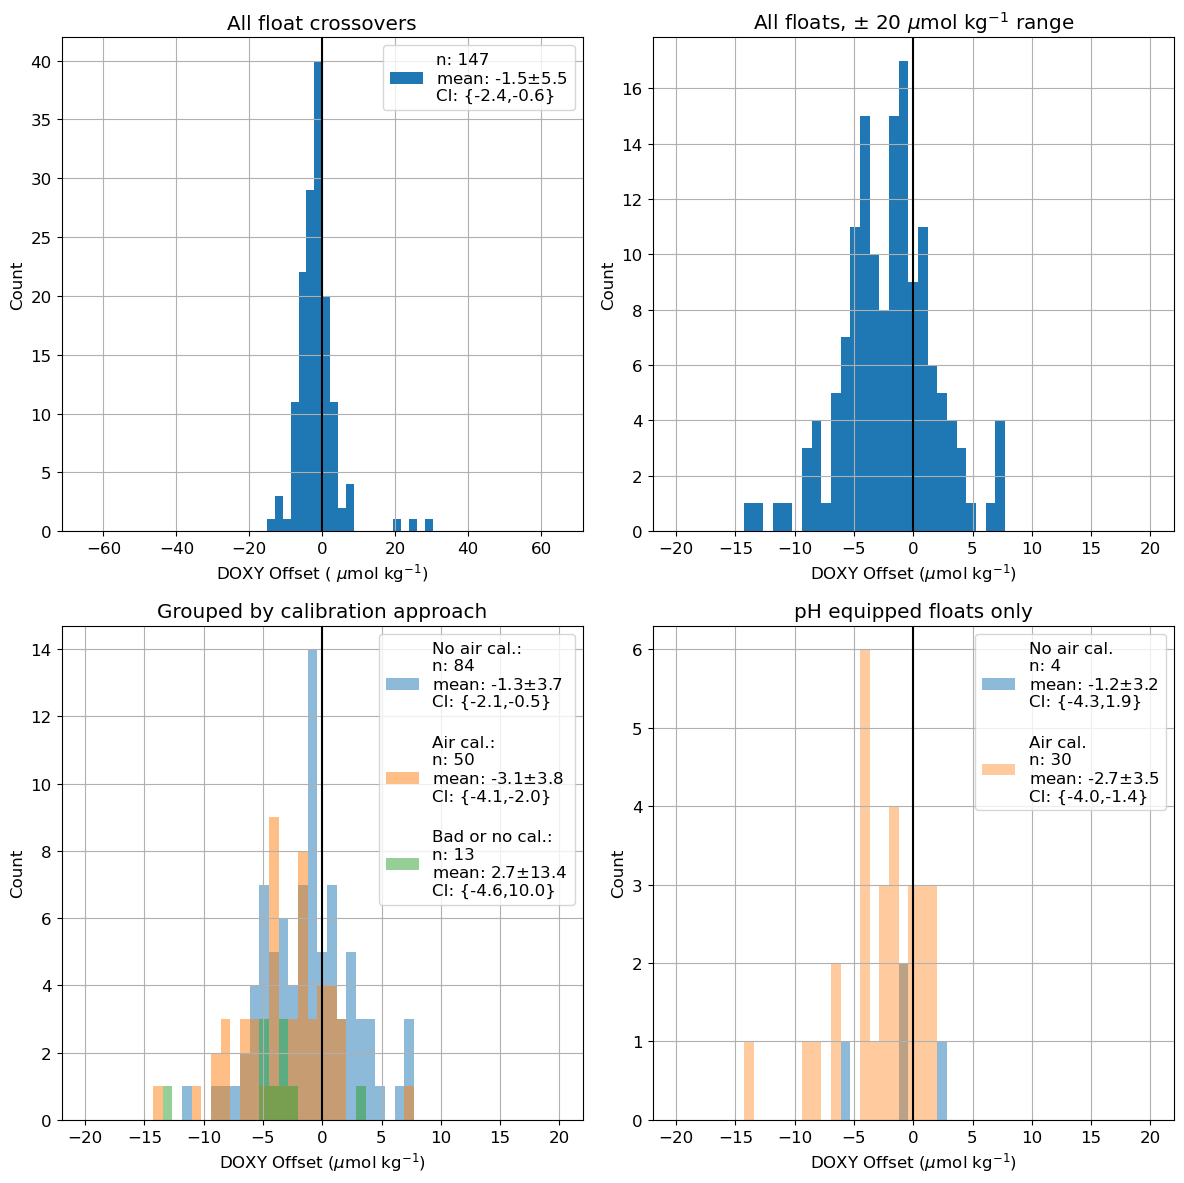

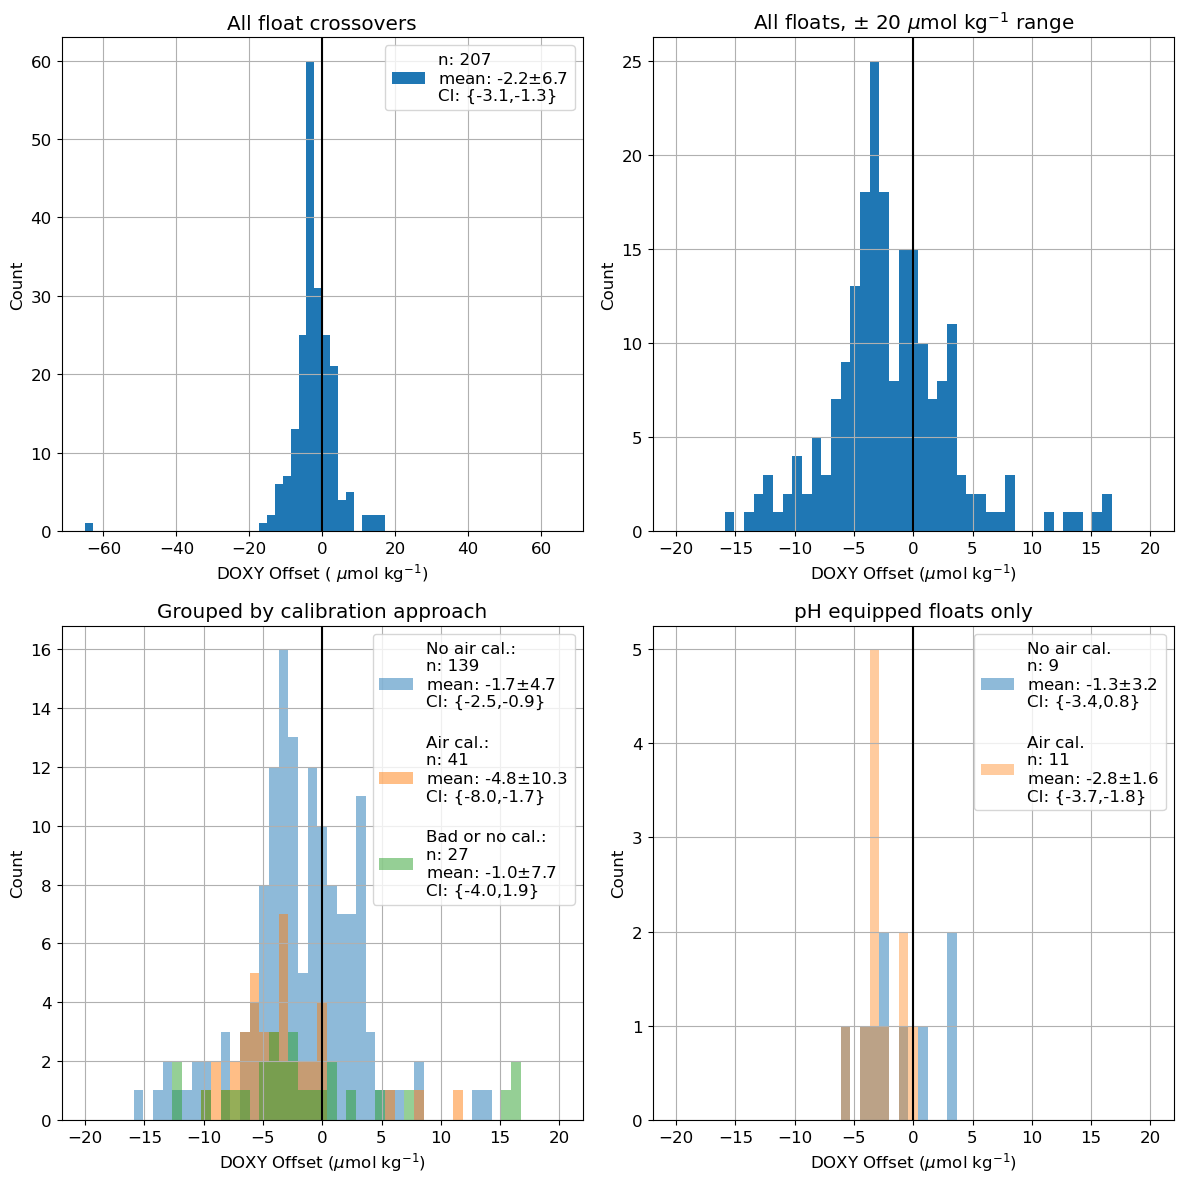

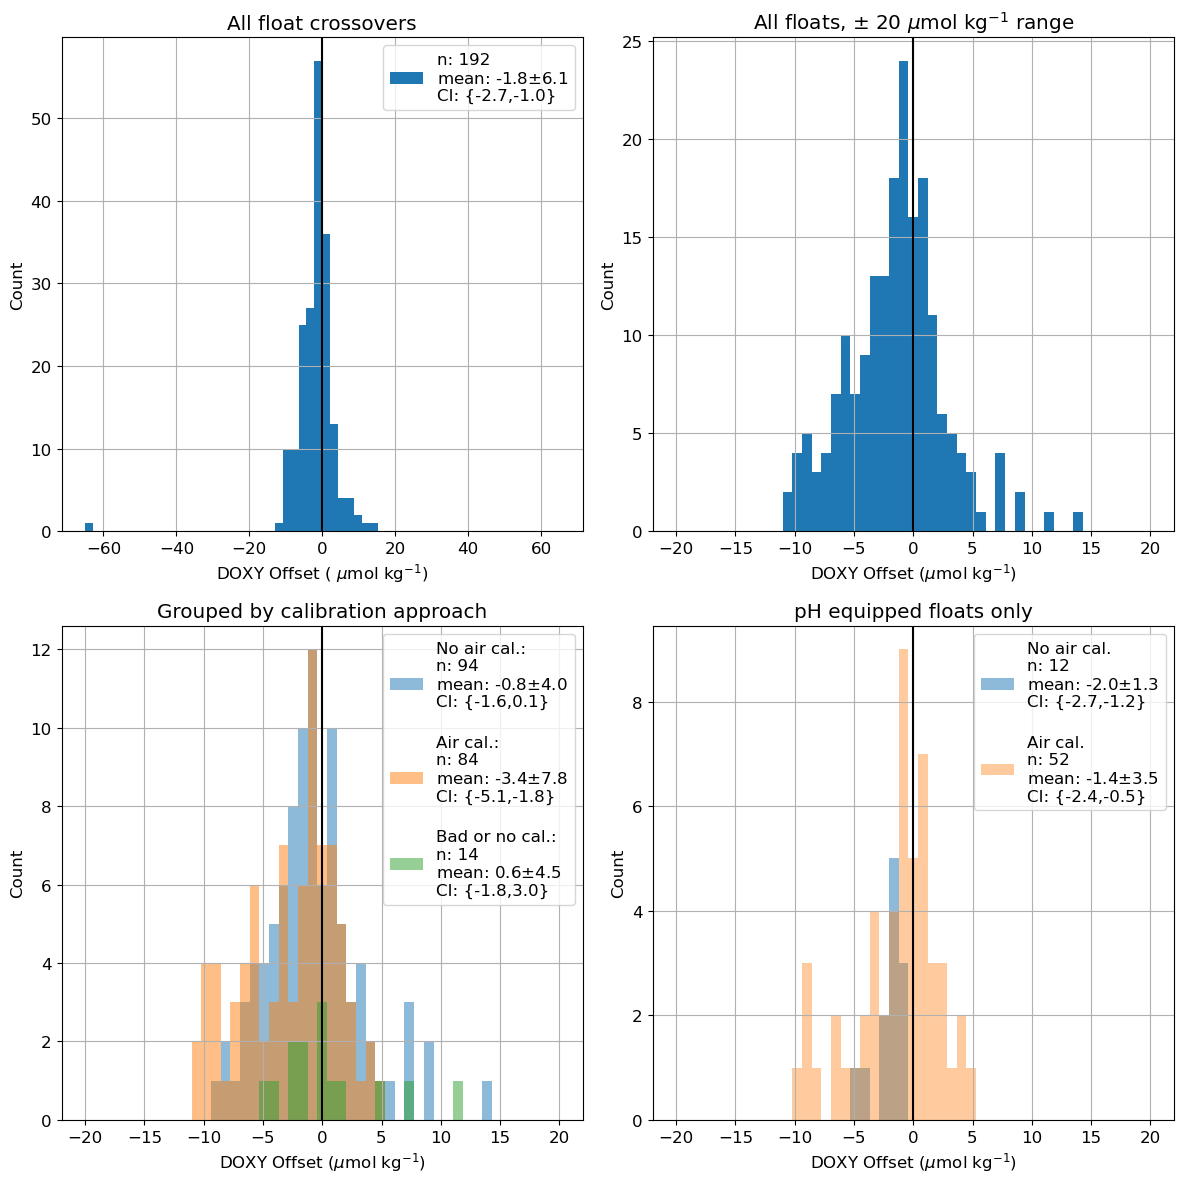

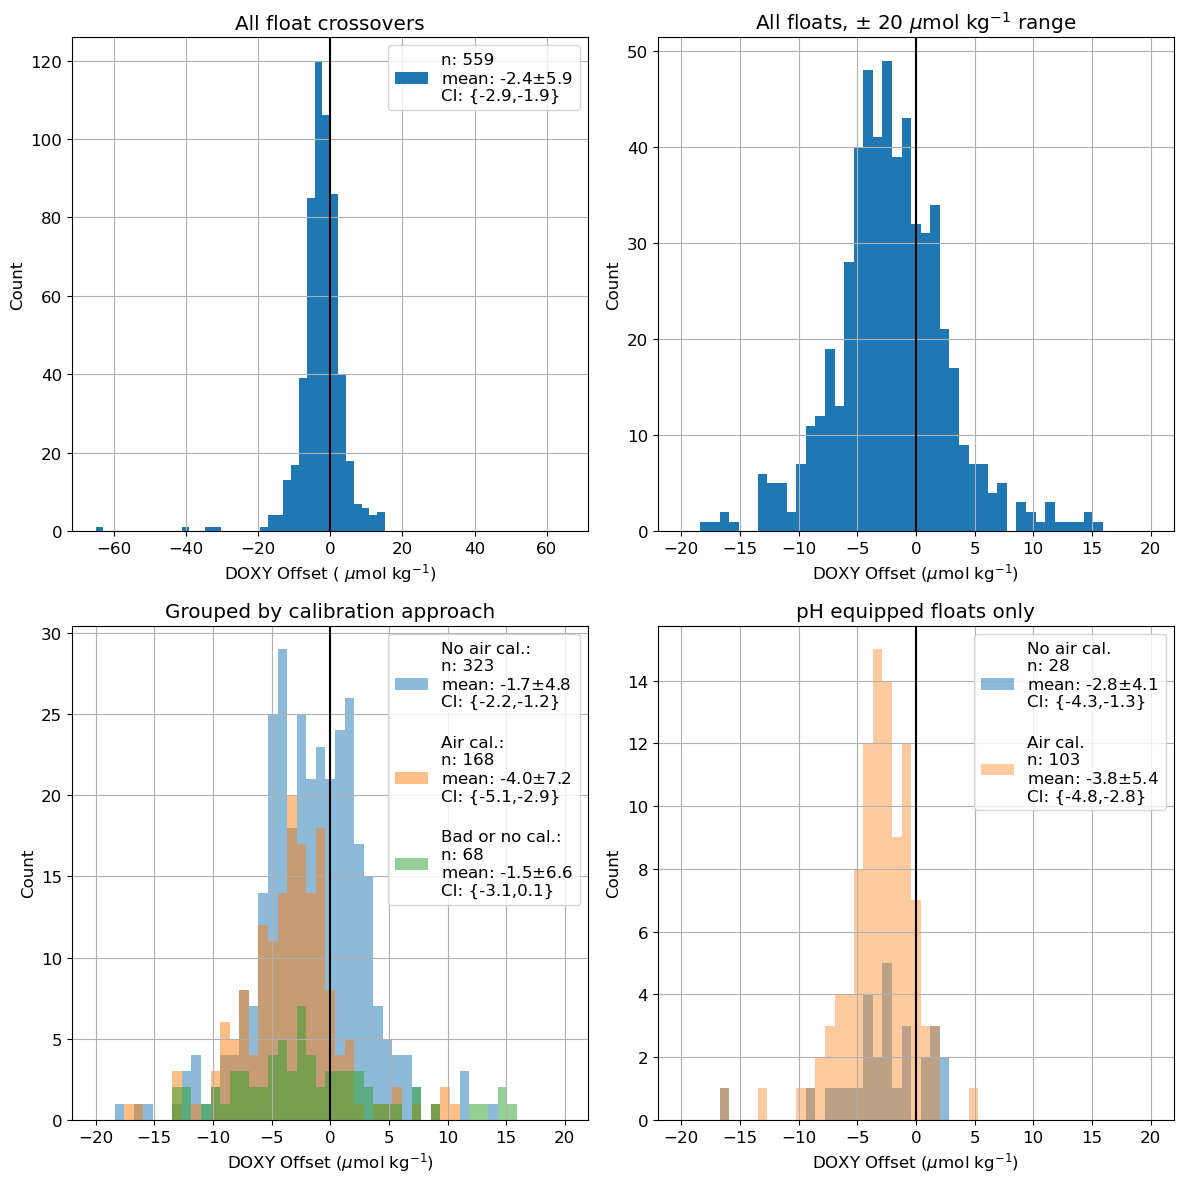

In [58]:
for file in days_list:
    print(file)
    if 'glodap_offsets_mean' in locals():
        glodap_offsets_mean.close()

    glodap_offsets_mean = xr.load_dataset(individual_plot_dir+file)
    glodap_offsets_p = glodap_offsets_mean.to_dataframe()

    parameter_a = 'o2_calib_air_group'
    parameter_b = 'pH_group'
    offsets_g = glodap_offsets_p.groupby(parameter_a)
    offsets_pH = glodap_offsets_p.groupby([parameter_a, parameter_b])
    CI_level = 0.95
    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(12,12))

    #All Float Crossovers
    plt.subplot(2,2,1)
    ncount = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].count()
    nmean = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)
    nmedian = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    nmin = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].min(), decimals=1)
    nmax = np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].max(), decimals=1)

    temp_var = glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed']
    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

    CI_vals = stats.norm.interval(alpha=CI_level, 
                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
    CI_low = np.around(CI_vals[0], decimals=1)
    CI_high = np.around(CI_vals[1], decimals=1)

    o2_offset_data_table = [('All', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax)]
    plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'], 
            bins=np.linspace(-65, 65, 61), label='n: '+str(ncount.values) +  '\nmean: ' + str(nmean.values) + '$\pm$' + str(nstd.values) + 
            '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}'
            ) # ,label=str(n)
    #print(np.around(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'].median().values, decimals=1))
    plt.grid()
    plt.title('All float crossovers')
    plt.xlabel(r'DOXY Offset ( $\mu$mol kg$^{-1}$)')
    plt.ylabel('Count')
    plt.axvline(x=0, color='k')
    plt.legend()

    # All float crossovers, zoomed in
    plt.subplot(2,2,2)
    plt.title('All floats, $\pm$ 20 $\mu$mol kg$^{-1}$ range')
    plt.hist(glodap_offsets_mean['DOXY_ADJUSTED_offset_trimmed'], 
            bins=np.linspace(-20, 20, 50),label='median='+str(nmedian.values) + 
            ', n='+str(ncount.values)) # ,label=str(n)
    plt.grid()
    plt.ylabel('Count')
    plt.axvline(x=0, color='k')

    plt.xlabel(r'DOXY Offset ($\mu$mol kg$^{-1}$)')

    # Split into calibration group
    plt.subplot(2,2,3)
    No_air_cal_all = offsets_g.get_group('no air cal')
    nmean = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)
    nmedian = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    ncount = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].count() # only counts non-nan values
    nmin = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].min(), decimals=1)
    nmax = np.around(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'].max(), decimals=1)

    temp_var = No_air_cal_all['DOXY_ADJUSTED_offset_trimmed']
    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

    CI_vals = stats.norm.interval(alpha=CI_level, 
                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
    CI_low = np.around(CI_vals[0], decimals=1)
    CI_high = np.around(CI_vals[1], decimals=1)
    o2_offset_data_table.append(('No air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


    plt.hist(No_air_cal_all['DOXY_ADJUSTED_offset_trimmed'], bins=np.linspace(-20, 20, 50),
                alpha=0.5,label='No air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
            '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')



    air_cal_all = offsets_g.get_group('air cal')
    nmean = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)
    nmedian = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    ncount = air_cal_all['DOXY_ADJUSTED_offset_trimmed'].count() # only counts non-nan values
    nmin = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].min(), decimals=1)
    nmax = np.around(air_cal_all['DOXY_ADJUSTED_offset_trimmed'].max(), decimals=1)

    temp_var = air_cal_all['DOXY_ADJUSTED_offset_trimmed']
    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

    CI_vals = stats.norm.interval(alpha=CI_level, 
                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
    CI_low = np.around(CI_vals[0], decimals=1)
    CI_high = np.around(CI_vals[1], decimals=1)

    o2_offset_data_table.append(('Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))


    plt.hist(air_cal_all['DOXY_ADJUSTED_offset_trimmed'], bins=np.linspace(-20, 20, 50),
                alpha=0.5,label='Air cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
            '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')


    no_cal_all = offsets_g.get_group('no cal/bad')
    nmean = np.around(no_cal_all['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nstd = np.around(no_cal_all['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)
    nmedian = np.around(no_cal_all['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    ncount = no_cal_all['DOXY_ADJUSTED_offset_trimmed'].count() # only counts non-nan values
    nmin = np.around(no_cal_all['DOXY_ADJUSTED_offset_trimmed'].min(), decimals=1)
    nmax = np.around(no_cal_all['DOXY_ADJUSTED_offset_trimmed'].max(), decimals=1)

    temp_var = no_cal_all['DOXY_ADJUSTED_offset_trimmed']
    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

    CI_vals = stats.norm.interval(alpha=CI_level, 
                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
    CI_low = np.around(CI_vals[0], decimals=1)
    CI_high = np.around(CI_vals[1], decimals=1)
    o2_offset_data_table.append(('No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

    plt.hist(no_cal_all['DOXY_ADJUSTED_offset_trimmed'], bins=np.linspace(-20, 20, 50),
                alpha=0.5,label='Bad or no cal.: \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
            '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')



    #for n, group in offsets_g:
    #    print(n)
    #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

        

    plt.title('Grouped by calibration approach')

    plt.axvline(x=0, color='k')
    plt.grid()
    plt.xlabel(r'DOXY Offset ($\mu$mol kg$^{-1}$)')
    plt.ylabel('Count')

    plt.legend()

    # pH equipped floats only 
    plt.subplot(2,2,4)
    plt.title('pH equipped floats only')

    no_air_cal_ph = offsets_pH.get_group(('no air cal', 'pH'))
    nmean = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nmedian = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    nstd = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)
    nmin = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].min(), decimals=1)
    nmax = np.around(no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].max(), decimals=1)

    ncount = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].count()

    temp_var = no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

    CI_vals = stats.norm.interval(alpha=CI_level, 
                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
    CI_low = np.around(CI_vals[0], decimals=1)
    CI_high = np.around(CI_vals[1], decimals=1)
    o2_offset_data_table.append(('pH - No cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

    plt.hist(no_air_cal_ph['DOXY_ADJUSTED_offset_trimmed'], bins=np.linspace(-20, 20, 50),
                alpha=0.5,label='No air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
            '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}\n')
    air_cal_ph = offsets_pH.get_group(('air cal', 'pH'))
    nmean = np.around(air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    nmedian = np.around(air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    ncount = air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].count()
    nstd = np.around(air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].std(), decimals=1)
    nmin = np.around(air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].min(), decimals=1)
    nmax = np.around(air_cal_ph['DOXY_ADJUSTED_offset_trimmed'].max(), decimals=1)

    temp_var = air_cal_ph['DOXY_ADJUSTED_offset_trimmed']
    t_stat, p_value = stats.ttest_1samp(a=temp_var, popmean=0, nan_policy='omit') ############

    CI_vals = stats.norm.interval(alpha=CI_level, 
                    loc=np.nanmean(temp_var[~np.isnan(temp_var)].values), 
                    scale = stats.sem(temp_var[~np.isnan(temp_var)].values))
    CI_low = np.around(CI_vals[0], decimals=1)
    CI_high = np.around(CI_vals[1], decimals=1)
    o2_offset_data_table.append(('pH - Air cal.', ncount, nmean, nstd, p_value, CI_low, CI_high, nmedian, nmin, nmax))

    plt.hist(air_cal_ph['DOXY_ADJUSTED_offset_trimmed'], bins=np.linspace(-20, 20, 50),
                alpha=0.4,label='Air cal. \nn: '+str(ncount) +  '\nmean: ' + str(nmean) + '$\pm$' + str(nstd) + 
            '\nCI: {' + str(CI_low) +',' +  str(CI_high) + '}')


    #for n, group in offsets_pH:
    #    if n[1] == 'no pH' or n[0] == 'no cal/bad':
    #        continue
    #    print(n)
    #    nmean = np.around(group['DOXY_ADJUSTED_offset_trimmed'].mean(), decimals=1)
    #    nmedian = np.around(group['DOXY_ADJUSTED_offset_trimmed'].median(), decimals=1)
    #    ncount = group['DOXY_ADJUSTED_offset_trimmed'].count()

    plt.xlabel(r'DOXY Offset ($\mu$mol kg$^{-1}$)')
    plt.ylabel('Count')
    plt.axvline(x=0, color='k')

    plt.legend()
        
    plt.tight_layout()
    plt.grid()
    plt.savefig(individual_plot_dir+ 'plots/' + 'Fig_4 Glodap_offsets_doxy_all_' + file + '.png', dpi=300)